<a href="https://colab.research.google.com/github/dooooing/2023-ESAA-/blob/main/%EC%8B%A0%EC%9A%A9%EC%B9%B4%EB%93%9C_%EC%BD%94%EB%93%9C_%EA%B3%B5%EC%9C%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

월간 데이콘 신용카드 사용자 연체 예측 AI 경진대회

https://dacon.io/competitions/official/235713/leaderboard

# LGBM

## 0. LIBRARY 불러오기

In [1]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import random

## 1. 데이터 전처리

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
submit = pd.read_csv('sample_submission.csv')

index 칼럼 삭제

In [4]:
train = train.drop(['index'], axis=1)
test = test.drop(['index'], axis=1)

missing value는 'NAN' 문자열로 대체

In [5]:
train.fillna('NAN', inplace=True)
test.fillna('NAN', inplace=True)

object(문자열) onehot encoding

In [6]:
object_col = []
for col in train.columns:
    if train[col].dtype == 'object':
        object_col.append(col)

In [7]:
enc = OneHotEncoder()
enc.fit(train.loc[:,object_col])


train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(),
             columns=enc.get_feature_names_out(object_col))
train.drop(object_col, axis=1, inplace=True)
train = pd.concat([train, train_onehot_df], axis=1)

In [8]:
test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(),
             columns=enc.get_feature_names_out(object_col))
test.drop(object_col, axis=1, inplace=True)
test = pd.concat([test, test_onehot_df], axis=1)

## 2. 모델링

stratifiedKFold를 사용해 y값 분포를 비슷하게 분리

In [9]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skf.split(train, train['credit']):
    folds.append((train_idx, valid_idx))

In [10]:
random.seed(42)
lgb_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values, train.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                         train['credit'][train_idx].values, train['credit'][valid_idx].values
    lgb = LGBMClassifier(n_estimators=1000)
    lgb.fit(X_train, y_train, eval_metric='logloss', eval_set=[(X_train, y_train), (X_valid, y_valid)])
    lgb_models[fold]=lgb
    print(f'================================================================================\n\n')

====================================1============================================
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 21165, number of used features: 53
[LightGBM] [Info] Start training from score -2.105723
[LightGBM] [Info] Start training from score -1.440314
[LightGBM] [Info] Start training from score -0.444119


====================================2============================================
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 819
[LightGBM] [Info] Number of data points in the train se

In [11]:
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += lgb_models[fold].predict_proba(test)/5

In [12]:
submit.to_csv('submit_lgbm.csv', index=False)

# Randomforest

## 0. LIBRARY 불러오기

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

## 1. 데이터 전처리

In [44]:
#load data
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')

### 결측치 제거

In [ ]:
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [ ]:
#결측치가 많은 변수(occyp_type) 제거하기
train=train.drop('occyp_type', axis=1)
test=test.drop('occyp_type', axis=1)

### Binary variables

In [ ]:
train['gender'] = train['gender'].replace(['F','M'],[0,1])
test['gender'] = test['gender'].replace(['F','M'],[0,1])
print('gender :')
print(train['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
train['car'] = train['car'].replace(['N','Y'],[0,1])
test['car'] = test['car'].replace(['N','Y'],[0,1])
print(train['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
train['reality'] = train['reality'].replace(['N','Y'],[0,1])
test['reality'] = test['reality'].replace(['N','Y'],[0,1])
print(train['reality'].value_counts())
print('--------------')

print('Having a phone or not: ')
print(train['phone'].value_counts())
print('--------------')

print('Having a email or not: ')
print(train['email'].value_counts())
print('--------------')


print('Having a work phone or not: ')
print(train['work_phone'].value_counts())
print('--------------')

gender :
0    17697
1     8760
Name: gender, dtype: int64
--------------
Having a car or not : 
0    16410
1    10047
Name: car, dtype: int64
--------------
Having house reality or not: 
1    17830
0     8627
Name: reality, dtype: int64
--------------
Having a phone or not: 
0    18672
1     7785
Name: phone, dtype: int64
--------------
Having a email or not: 
0    24042
1     2415
Name: email, dtype: int64
--------------
Having a work phone or not: 
0    20511
1     5946
Name: work_phone, dtype: int64
--------------


### Continuous variable

(1) child_num

<Axes: >

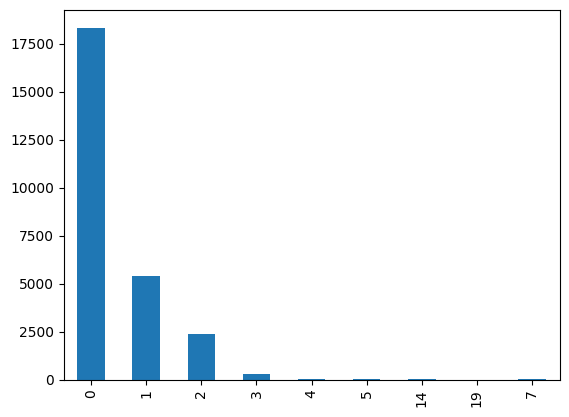

In [ ]:
train['child_num'].value_counts(sort=False).plot.bar()

In [ ]:
#2이상의 값은 그 값이 매우 작음 -> 하나로 합치기
train.loc[train['child_num'] >= 2,'child_num']=2
test.loc[test['child_num']>=2, 'child_num']=2

In [ ]:
train['child_num'].value_counts()

0    18340
1     5386
2     2731
Name: child_num, dtype: int64

(2) inc

(2.544, 18.18]      16212
(18.18, 33.66]       8330
(33.66, 49.14]       1530
(49.14, 64.62]        206
(64.62, 80.1]         121
(80.1, 95.58]          44
(95.58, 111.06]         3
(111.06, 126.54]        2
(126.54, 142.02]        4
(142.02, 157.5]         5
Name: income_total, dtype: int64


<Axes: ylabel='Frequency'>

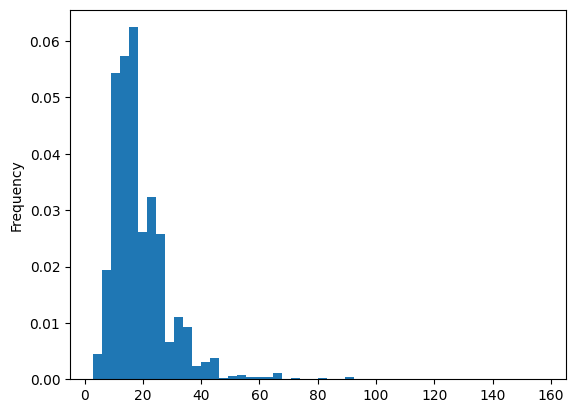

In [ ]:
train['income_total'] = train['income_total'].astype(object)
train['income_total'] = train['income_total']/10000
test['income_total'] = test['income_total']/10000
##############################################################3
print(train['income_total'].value_counts(bins=10,sort=False))
train['income_total'].plot(kind='hist',bins=50,density=True)

In [ ]:
#어떻게 처리한건지 긴가민가
count, bin_dividers =np.histogram(train['income_total'], bins=7)
bin_names=['소득'+str(i) for i in range(7) ]
#bin_dividers는 train기준!!
train['income_total']=pd.cut(x=train['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)
test['income_total']=pd.cut(x=test['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)

In [ ]:
test.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month
0,26457,1,1,0,0,소득0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,2.0,-60.0
1,26458,0,0,1,0,소득0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,2.0,-36.0
2,26459,0,0,1,0,소득0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,2.0,-40.0
3,26460,1,1,0,0,소득0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,2.0,-41.0
4,26461,0,1,1,0,소득0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,2.0,-8.0


(3) Type

In [ ]:
print(train['income_type'].unique())
print(train['edu_type'].unique())
print(train['family_type'].unique())
print(train['house_type'].unique())

['Commercial associate' 'Working' 'State servant' 'Pensioner' 'Student']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
['Married' 'Civil marriage' 'Separated' 'Single / not married' 'Widow']
['Municipal apartment' 'House / apartment' 'With parents'
 'Co-op apartment' 'Rented apartment' 'Office apartment']


In [ ]:
#object type label encoding
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()

train['income_type']=label_encoder.fit_transform(train['income_type'])
test['income_type']=label_encoder.transform(test['income_type'])

train['edu_type']=label_encoder.fit_transform(train['edu_type'])
test['edu_type']=label_encoder.transform(test['edu_type'])

train['family_type']=label_encoder.fit_transform(train['family_type'])
test['family_type']=label_encoder.transform(test['family_type'])

train['house_type']=label_encoder.fit_transform(train['house_type'])
test['house_type']=label_encoder.transform(test['house_type'])

train['income_total']=label_encoder.fit_transform(train['income_total'])
test['income_total']=label_encoder.fit_transform(test['income_total'])

In [ ]:
test.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month
0,26457,1,1,0,0,0,1,4,0,1,-21990,365243,1,0,1,0,2.0,-60.0
1,26458,0,0,1,0,0,2,1,1,1,-18964,-8671,1,0,1,0,2.0,-36.0
2,26459,0,0,1,0,0,4,4,1,1,-15887,-217,1,1,1,0,2.0,-40.0
3,26460,1,1,0,0,0,0,4,1,1,-19270,-2531,1,1,0,0,2.0,-41.0
4,26461,0,1,1,0,0,2,1,1,1,-17822,-9385,1,1,0,0,2.0,-8.0


4. Minus continuous variable

In [ ]:
#minus 변경하고
#구간화 함수
def make_bin(variable, n):
    train[variable]=-train[variable]
    test[variable]=-test[variable]
    count, bin_dividers =np.histogram(train[variable], bins=n) #train의 구간화를 적용
    bin_names=[str(i) for i in range(n)]
    train[variable]=pd.cut(x=train[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    test[variable]=pd.cut(x=test[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    test[variable].fillna(str(0), inplace=True) #test에는 없는 것을 임의의 값으로 채움

    train[variable]=label_encoder.fit_transform(train[variable])
    test[variable]=label_encoder.transform(test[variable])

In [ ]:
train.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'family_size', 'begin_month', 'credit'],
      dtype='object')

In [ ]:
make_bin('DAYS_BIRTH', n=10)
make_bin('DAYS_EMPLOYED', n=6)
make_bin('begin_month', n=4)

In [ ]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
0,0,0,0,0,0,0,0,1,1,2,3,1,1,0,0,0,2.0,0,1.0
1,1,0,0,1,1,0,0,4,0,1,2,1,1,0,0,1,3.0,0,1.0
2,2,1,1,1,0,1,4,1,1,1,6,1,1,0,1,0,2.0,1,2.0
3,3,0,0,1,0,0,0,4,1,1,4,1,1,0,1,0,2.0,2,0.0
4,4,0,1,1,0,0,2,1,1,1,4,1,1,0,0,0,2.0,1,2.0


In [ ]:
train.shape

(26457, 19)

In [ ]:
test.shape

(10000, 18)

## 2. 모델링

###데이터 모델링

In [ ]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test

In [ ]:
print(train_x.shape, train_y.shape, test.shape)

(26457, 18) (26457, 1) (10000, 18)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y,
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)


clf=RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

Train set: 
(19842, 18)
(19842, 1)
Validation set: 
(6615, 18)
(6615, 1)
log_loss: 1.063960933648772


In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)

        predictions=clf.predict_proba(X_val)

        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")

        sub+=clf.predict_proba(test_x)


    mean_outcome=np.mean(outcomes)

    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(clf)

FOLD 0 : logloss:1.0214852567611605
FOLD 1 : logloss:1.0747999049033872
FOLD 2 : logloss:1.1135512078071765
FOLD 3 : logloss:1.009977920689099
FOLD 4 : logloss:1.0528366188638285
Mean:1.0545301818049304


In [ ]:
my_submission

array([[0.102, 0.212, 0.686],
       [0.08 , 0.21 , 0.71 ],
       [0.084, 0.22 , 0.696],
       ...,
       [0.06 , 0.096, 0.844],
       [0.12 , 0.372, 0.508],
       [0.152, 0.372, 0.476]])

In [ ]:
submission.loc[:,1:]=my_submission

In [ ]:
submission

,index,0,1,2
0,26457,0.102,0.212,0.686
1,26458,0.080,0.210,0.710
2,26459,0.084,0.220,0.696
3,26460,0.130,0.204,0.666
4,26461,0.114,0.374,0.512
...,...,...,...,...
9995,36452,0.106,0.300,0.594
9996,36453,0.144,0.396,0.460
9997,36454,0.060,0.096,0.844
9998,36455,0.120,0.372,0.508


In [ ]:
submission.to_csv('baseline_submission_rf.csv', index=False)

### random forest

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y,
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rfmodel = RandomForestClassifier()
params={'max_depth':[6,8,10,12],'min_samples_leaf':[8,12,18],'min_samples_split':[8,6,20]}
gridsearchrf=GridSearchCV(rfmodel,params,cv=5)
gridsearchrf.fit(X_train, y_train)
gridsearchrf.best_params_

{'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 8}

In [ ]:
modelrf = RandomForestClassifier(max_features=0.2,n_estimators=500, max_depth=12, min_samples_leaf=8, min_samples_split=8)
modelrf.fit(X_train, y_train)
y_pred=clf.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

log_loss: 0.3749183661558909


In [ ]:
my_submission = run_kfold(modelrf)

FOLD 0 : logloss:0.8501157289877844
FOLD 1 : logloss:0.8482030206924189
FOLD 2 : logloss:0.8477730151269953
FOLD 3 : logloss:0.8464854691043053
FOLD 4 : logloss:0.8467228708966847
Mean:0.8478600209616378


In [ ]:
my_submission

array([[0.11203905, 0.21057531, 0.67738564],
       [0.10890347, 0.19837092, 0.69272561],
       [0.1108562 , 0.22681668, 0.66232712],
       ...,
       [0.09718196, 0.1964146 , 0.70640344],
       [0.11616926, 0.23121348, 0.65261725],
       [0.11558642, 0.30599837, 0.57841521]])

In [ ]:
submission.loc[:,1:]=my_submission

In [ ]:
submission.to_csv('submission_rf.csv', index=False)

# Catboost

# 0. Library

In [42]:
!pip install catboost
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.5 MB/s eta 0:00:00


In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

# Staking Ensemble

## 0. Library

In [20]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.6 MB/s eta 0:00:00


In [21]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split,GridSearchCV
from tqdm import tqdm

from pathlib import Path
import warnings
warnings.filterwarnings(action = 'ignore')

## 1. 데이터 전처리

### feature set 1

In [22]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

변수 변환 및 제거, 라벨 인코딩, type 변환, 파생 변수 생성

In [25]:
for data in [train, test]:

    ## 변수 변환
    data['birth_plus'] = data.DAYS_BIRTH*(-1)/365

    ## 라벨 인코딩
    data['gender']=LabelEncoder().fit_transform(data.gender)
    data['car']=LabelEncoder().fit_transform(data.car)
    data['reality']=LabelEncoder().fit_transform(data.reality)
    data['income_type']=LabelEncoder().fit_transform(data.income_type)
    data['edu_type']=LabelEncoder().fit_transform(data.edu_type)
    data['family_type']=LabelEncoder().fit_transform(data.family_type)
    data['house_type']=LabelEncoder().fit_transform(data.house_type)
    data.fillna('NAN',inplace=True)
    data['occyp_type']=LabelEncoder().fit_transform(data.occyp_type)
    data['income_weight']=data.income_total**2
    data['income_age']=data.income_total*train.DAYS_BIRTH
    data['income_emp']=data.income_total*train.DAYS_EMPLOYED

    ## type 변환
    data.income_total=data.income_total.astype(int)
    data.family_size=data.family_size.astype(int)
    data.begin_month=data.begin_month.astype(int)
    data.birth_plus=data.birth_plus.astype(int)

    ## 변수 제거
    data.drop(['index','family_size','work_phone'],axis=1,inplace=True)

    ## 파생 변수 생성
    data.DAYS_BIRTH=data.DAYS_BIRTH**6
    data.income_type=1/(data.income_type)
    data.income_weight=1/(data.income_weight)**3
    data['DAYS_BIRTH_weight']=1/(data.DAYS_BIRTH)**2

catboost에 맞춰 전처리

In [26]:
cat_credit=train.credit.astype('int').copy()
train.credit=train.credit.astype('category')

feature set 1 저장

In [27]:
ftr1 = train.drop('credit', axis=1).values
target1 = train['credit'].values
tst_ar1 = test.values
n_class = 3

### feature set 2

In [28]:
trn = pd.read_csv('train.csv')
tst = pd.read_csv('test.csv')

변수 변환

In [29]:
## 365 변환
def days_to_plus(x):
    return (x*-1)/365

## 업무 시작일 변환
def plus(x):
    if x<0:
        return x*(-1)
    else:
        return 0

## 변수 변환 (업무 시작일과 나이)
for i in [trn, tst]:
    i['birth_plus'] = i.DAYS_BIRTH.map(days_to_plus)
    i['employed_plus'] = i.DAYS_EMPLOYED.map(days_to_plus)

라벨 인코딩

In [30]:
index_col = 'index'
target_col = 'credit'

cat_cols = [x for x in trn.columns if trn[x].dtype == 'object']
float_cols = [x for x in trn.columns.drop('credit') if trn[x].dtype == 'float64']
num_cols = [x for x in trn.columns if x not in cat_cols + [target_col]]
feature_cols = num_cols + cat_cols

lbe = LabelEncoder()
for i in cat_cols:
    trn[i] = lbe.fit_transform(trn[i].astype(str))
    tst[i] = lbe.transform(tst[i].astype(str))

for i in float_cols:
    trn[i] = trn[i].astype('int')
    tst[i] = tst[i].astype('int')

인덱스 설정 및 변수 제거

In [31]:
for i in [trn, tst]:
    i.set_index('index', inplace = True)
    i.drop(['family_size', 'employed_plus'], axis = 1, inplace = True)

파생 변수 생성

In [32]:
for i in [trn,tst]:
    # 연봉 제곱 변수 제거
    i['income_total_2'] = i.income_total**2

    # DAYS_BIRTH 제곱 변수 추가
    i['DAYS_BIRTH**2'] = i.DAYS_BIRTH**2

    # income * days_birth
    i['income_age'] = i.income_total*i.DAYS_BIRTH

    # income * DAYS_EMPLOYED
    i['income_emp'] = i.income_total*i.DAYS_EMPLOYED

데이터 재표현

In [33]:
for i in [trn, tst]:
    i['DAYS_BIRTH**2'] = np.log1p(i['DAYS_BIRTH**2'])
    i['income_total_2'] = i.income_total_2**2
    i['income_emp'] = i.income_emp**2
    i['income_age'] = i.income_age**3

변수 타입 전환

In [34]:
for i in [trn, tst]:
    i['income_total'] = i.income_total.astype(int)
    i['DAYS_BIRTH**2'] = i['DAYS_BIRTH**2'].astype(int)
trn.credit = trn.credit.astype('category')

feature set 2 저장

In [35]:
ftr2 = trn.drop('credit', axis=1).values
target2 = trn['credit'].values
tst_ar2 = tst.values
n_class = 3

## 2. 모델링

### LGB 1

In [36]:
n_fold = 17
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=40)

print(ftr1.shape)

lgb_p_val1 = np.zeros((ftr1.shape[0], n_class))
lgb_p_tst1 = np.zeros((tst_ar1.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(ftr1, target1), 1):
    print(f'training model for CV #{i}')
    lgb_clf = LGBMClassifier(max_depth=24,
                       num_leaves=110,
                       colsample_bytree=0.3,
                       n_estimators=230,
                       min_child_samples=2,
                       subsample=0.9,
                       subsample_freq=2,
                       learning_rate=0.09,
                       random_state=2021,
                       verbose = 50)

    lgb_clf.fit(ftr1[i_trn], target1[i_trn],
            eval_set=[(ftr1[i_val], target1[i_val])])

    lgb_p_val1[i_val, :] = lgb_clf.predict_proba(ftr1[i_val])
    lgb_p_tst1 += lgb_clf.predict_proba(tst_ar1) / n_fold

print(f'{log_loss(target1, lgb_p_val1)}')
print(f'{confusion_matrix(target1, np.argmax(lgb_p_val1, axis=1))}%')

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Debug] Re-bagging, using 22399 data to train
[LightGBM] [Debug] Trained a tree with leaves = 110 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 110 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 110 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 110 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 110 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 110 and depth = 22
[LightGBM] [Debug] Re-bagging, using 22453 data to train
[LightGBM] [Debug] Trained a tree with leaves = 110 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 110 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 110 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 110 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 110 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 110 and depth = 19
[LightGBM] [Debug] Re-bagging, using 22381 dat

In [41]:
from pathlib import Path
tst_dir = Path("C:/Users/byuls/credit")
val_dir = Path("C:/Users/byuls/credit")

algo_name = 'lgb'
feature_name = '2021_j'
model_name = f'{algo_name}_{feature_name}'

p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'

np.savetxt(p_val_file, lgb_p_val1, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, lgb_p_tst1, fmt='%.6f', delimiter=',')

FileNotFoundError: ignored

### LGB_2

In [ ]:
n_fold = 17
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=40)

print(ftr1.shape)

lgb_p_val2 = np.zeros((ftr1.shape[0], n_class))
lgb_p_tst2 = np.zeros((tst_ar1.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(ftr1, target1), 1):
    print(f'training model for CV #{i}')
    lgb_clf = lgb.LGBMClassifier(max_depth=24,
                       num_leaves=110,
                       colsample_bytree=0.3,
                       n_estimators=175,
                       min_child_samples=2,
                       subsample=0.9,
                       subsample_freq=2,
                       learning_rate=0.09,
                       random_state=2021,
                       verbose = 0)

    lgb_clf.fit(ftr1[i_trn], target1[i_trn],
            eval_set=[(ftr1[i_val], target1[i_val])])

    lgb_p_val2[i_val, :] = lgb_clf.predict_proba(ftr1[i_val])
    lgb_p_tst2 += lgb_clf.predict_proba(tst_ar1) / n_fold

print(f'{log_loss(target1, lgb_p_val2)}')
print(confusion_matrix(target1, np.argmax(lgb_p_val2, axis=1)))

In [ ]:
from pathlib import Path
tst_dir = Path('C:/Users/Roh Seung Chan/Desktop/공모전/신용카드 예측 공모전/data/tst')
val_dir = Path('C:/Users/Roh Seung Chan/Desktop/공모전/신용카드 예측 공모전/data/val')

algo_name = 'lgb'
feature_name = '2021'
model_name = f'{algo_name}_{feature_name}'

p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'

np.savetxt(p_val_file, lgb_p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, lgb_p_tst, fmt='%.6f', delimiter=',')